# Experiment with complete Lagrangian from exponentiated gradient as grid for grid search

In this, we compare time, violation and error from expgrad on full dataset, gridsearch on full dataset, hybrid model with various fractions of subsets.

### Notes:

1. For hybrid model, we report 2 values - expgrad on partial dataset and grid search by re-training all classifiers with output lagrangian of expgrad.

2. As predict may give variable results (due to randomisation), `_pmf_predict` is used to get the value of the `y_pred` for exp grad (in both cases - on partial and also on full dataset).

3. Normalised values are calculated by: `({value}-{eps}) / {eps}` for violation and `({value}-{expgrad on full dataset})/{expgrad on full dataset}` for error.


In [1]:
# load data
import numpy as np
import pandas as pd
from datetime import datetime 
from IPython.display import display, HTML
import statistics 

import shap
shap.initjs()

from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

X, Y = shap.datasets.adult()
sensitive_attribute = 'Sex'

A = X[sensitive_attribute]
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

X = X.reset_index(drop=True)
A = A.reset_index(drop=True)

X_train_all = pd.DataFrame(X)
A_train_all = pd.Series(A)
y_train_all = pd.Series(Y)

# Combine all training data into a single data frame and glance at a few rows
train_all = pd.concat([X_train_all, y_train_all, A_train_all], axis=1)


Bad key "text.kerning_factor" on line 4 in
/Users/parulgupta/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Subsampling process
#fractions = [0.01,0.05,0.1,0.2,0.5,0.8,0.9,1]
#fractions = [0.01,0.05]
num_samples = 2
fractions = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.8]
eps = 0.008
# A_trains = []
# X_trains = []
# y_trains = []

# for f in fractions: 
#     subsampling = train_all.sample(frac=f)
#     subsampling = subsampling.reset_index()
#     subsampling = subsampling.drop(columns=['index'])
#     tmp = subsampling.iloc[:, :-1]
#     A_train = subsampling.iloc[:, -1]
#     X_train = tmp.iloc[:, :-1]
#     y_train = tmp.iloc[:,-1]
#     A_trains.append(A_train)
#     X_trains.append(X_train)
#     y_trains.append(y_train)

In [3]:
#Unmitigated LogRes
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train_all, y_train_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [4]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate
import numpy as np

In [5]:
# Error & Violation of unmitigated estimator
def UnmitLogistic(X): return logistic_learner.predict(X)
# violation
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
log_violation_unmitigated = disparity_moment.gamma(UnmitLogistic).max()

# error
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_error_unmitigated = error.gamma(UnmitLogistic)[0]
print('Logistic Regression - Violation: {}, Error: {}'.format(
    log_violation_unmitigated, log_error_unmitigated))

Logistic Regression - Violation: 0.12424042105058944, Error: 0.1586253493443076


In [6]:
# Expgrad on full dataset
expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(), eps=eps, nu=1e-6)

a=datetime.now()
expgrad_X_logistic.fit(X_train_all, y_train_all,
                       sensitive_features=A_train_all)
b=datetime.now()
time_expgrad_all = (b-a).seconds

def Qexp_all(X): return expgrad_X_logistic._pmf_predict(X)[:, 1]
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all,
                sensitive_features=A_train_all)
error_expgrad_all = error.gamma(Qexp_all)[0]

print('Exponentiated gradient on full dataset : Time: {} seconds; Violation: {}; Errror: {}'.format(
    time_expgrad_all, violation_expgrad_all, error_expgrad_all))

Exponentiated gradient on full dataset : Time: 61 seconds; Violation: 0.007999999999999924; Errror: 0.17583524270832335


In [7]:
# grid search with 0 as center
grid_X_logistic = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                             constraints=DemographicParity())

a=datetime.now()
grid_X_logistic.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
time_grid_all = (b-a).seconds

def Qgrid_all(X): return grid_X_logistic.predict(X)
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
violation_grid_all = disparity_moment.gamma(Qgrid_all).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
error_grid_all = error.gamma(Qgrid_all)['all']

print('Grid Search on full dataset with 0 offset: Time: {} seconds; Violation: {}; Errror: {}'.format(
    time_grid_all, violation_grid_all, error_grid_all))


Grid Search on full dataset with 0 offset: Time: 32 seconds; Violation: 0.053235051159029406; Errror: 0.16535118700285617


## Experiment 1: Hybrid 1

### Notes:

1. For grid search in hybrid model, we get `y_pred` using the best classifier out of all the predictors.

In [8]:
# hybrid model

# Variables
time_expgrad_fracs = []
time_grid_fracs = []
time_hybrids = []
time_expgrad_alls = []
time_grid_alls = []

error_expgrad_fracs = []
error_grid_fracs = []
error_hybrids = []
error_expgrad_alls = []
error_grid_alls = []

vio_expgrad_fracs = []
vio_grid_fracs = []
vio_hybrids = []
vio_expgrad_alls = []
vio_grid_alls = []


error_expgrad_fracs_std = []
error_grid_fracs_std = []
error_hybrids_std = []

vio_expgrad_fracs_std = []
vio_grid_fracs_std = []
vio_hybrids_std = []

# Iterations on difference fractions
for i,f in enumerate(fractions):
    time_expgrad_alls.append(time_expgrad_all)
    error_expgrad_alls.append(error_expgrad_all)
    vio_expgrad_alls.append(violation_expgrad_all)

    time_grid_alls.append(time_grid_all)
    error_grid_alls.append(error_grid_all)
    vio_grid_alls.append(violation_grid_all)
    
    _time_expgrad_fracs = []
    _time_grid_fracs = []
    _time_hybrids = []

    _error_expgrad_fracs = []
    _error_grid_fracs = []
    _error_hybrids = []
    
    
    _vio_expgrad_fracs = []
    _vio_grid_fracs = []
    _vio_hybrids = []

    for n in range(num_samples):
        
        # get samples
        subsampling = train_all.sample(frac=f, random_state=n)
        subsampling = subsampling.reset_index()
        subsampling = subsampling.drop(columns=['index'])
        tmp = subsampling.iloc[:, :-1]
        A_train = subsampling.iloc[:, -1]
        X_train = tmp.iloc[:, :-1]
        y_train = tmp.iloc[:,-1]

        # Expgrad on sub dataset
        expgrad_X_logistic_frac = ExponentiatedGradient(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), eps=eps, nu=1e-6)

        a=datetime.now()  
        expgrad_X_logistic_frac.fit(X_train, y_train, sensitive_features=A_train)
        b=datetime.now()
        time_expgrad_frac = (b-a).seconds
        _time_expgrad_fracs.append(time_expgrad_frac)

        def Qexp(X): return expgrad_X_logistic_frac._pmf_predict(X)[:, 1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all,
                                   sensitive_features=A_train_all)
        violation_expgrad_logistic_frac = disparity_moment.gamma(Qexp).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all,
                        sensitive_features=A_train_all)
        error_expgrad_logistic_frac = error.gamma(Qexp)[0]

        _error_expgrad_fracs.append(error_expgrad_logistic_frac)
        _vio_expgrad_fracs.append(violation_expgrad_logistic_frac)


        # Grid Search part
        lambda_vecs_logistic = expgrad_X_logistic_frac._lambda_vecs_lagrangian
        grid_search_logistic_frac = GridSearch(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), grid=lambda_vecs_logistic)
        a=datetime.now()  
        grid_search_logistic_frac.fit(X_train_all, y_train_all,
                                      sensitive_features=A_train_all)
        b=datetime.now()
        time_grid_frac = (b-a).seconds
        _time_grid_fracs.append(time_grid_frac)
        _time_hybrids.append(time_grid_frac + time_expgrad_frac)

        def Qgrid(X): return grid_search_logistic_frac.predict(X)
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all,
                                   sensitive_features=A_train_all)
        violation_grid_frac = disparity_moment.gamma(Qgrid).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all,
                        sensitive_features=A_train_all)
        error_grid_frac = error.gamma(Qgrid)['all']

        _vio_hybrids.append(violation_grid_frac)
        _error_hybrids.append(error_grid_frac)

        _vio_grid_fracs.append(violation_grid_frac)
        _error_grid_fracs.append(error_grid_frac)

    time_expgrad_fracs.append((sum(_time_expgrad_fracs)) / num_samples) 
    time_grid_fracs.append((sum(_time_grid_fracs)) / num_samples)
    time_hybrids.append((sum(_time_hybrids)) / num_samples)

    error_expgrad_fracs.append((sum(_error_expgrad_fracs)) / num_samples)
    error_grid_fracs.append((sum(_error_grid_fracs)) / num_samples)
    error_hybrids.append((sum(_error_hybrids)) / num_samples)
    
    vio_expgrad_fracs.append((sum(_vio_expgrad_fracs)) / num_samples)
    vio_grid_fracs.append((sum(_vio_grid_fracs)) / num_samples)
    vio_hybrids.append((sum(_vio_hybrids)) / num_samples)
    
    error_expgrad_fracs_std.append(statistics.stdev(_error_expgrad_fracs))
    error_grid_fracs_std.append(statistics.stdev(_error_grid_fracs))
    error_hybrids_std.append(statistics.stdev(_error_hybrids))
    vio_expgrad_fracs_std.append(statistics.stdev(_vio_expgrad_fracs))
    vio_grid_fracs_std.append(statistics.stdev(_vio_grid_fracs))
    vio_hybrids_std.append(statistics.stdev(_vio_hybrids))
    

Model			Fraction	Time Taken (in secs)	
Exp.Grad. on full	-		61
Grid Search on full	-		32
---------------------------------------------
Exp.Grad. on subset	0.001		0.5
Exp.Grad. on subset	0.005		1.5
Exp.Grad. on subset	0.01		2.0
Exp.Grad. on subset	0.05		3.5
Exp.Grad. on subset	0.1		6.0
Exp.Grad. on subset	0.5		27.5
Exp.Grad. on subset	0.8		42.5
---------------------------------------------
Hybrid (Total time)	0.001		10.0
Hybrid (Total time)	0.005		23.0
Hybrid (Total time)	0.01		27.0
Hybrid (Total time)	0.05		24.5
Hybrid (Total time)	0.1		27.5
Hybrid (Total time)	0.5		59.5
Hybrid (Total time)	0.8		70.5


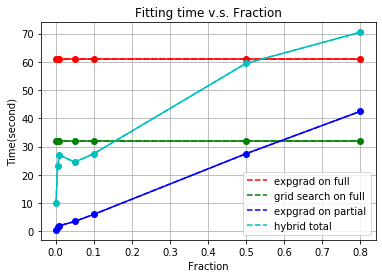

In [9]:
# Print Time and plot them

print('Model\t\t\tFraction\tTime Taken (in secs)\t')
print('{}\t{}\t\t{}'.format('Exp.Grad. on full', '-', time_expgrad_alls[0]))
print('{}\t{}\t\t{}'.format('Grid Search on full', '-', time_grid_alls[0]))
print('---------------------------------------------')
for i in range(len(fractions)):
    print('{}\t{}\t\t{}'.format('Exp.Grad. on subset',
                                fractions[i], time_expgrad_fracs[i]))
    
print('---------------------------------------------')
for i in range(len(fractions)):
    print('{}\t{}\t\t{}'.format('Hybrid (Total time)',
                                fractions[i], time_hybrids[i]))
    

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, time_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, time_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, time_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, time_hybrids,'c--',label="hybrid total")
plt.plot(fractions, time_expgrad_alls,'ro-', fractions, time_grid_alls,'go-',
         fractions, time_expgrad_fracs,'bo-', fractions, time_hybrids,'co-')
plt.xlabel('Fraction')
plt.ylabel('Time(second)')
plt.title('Fitting time v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

Model			Fraction	Error	Normalised Error
Exp.Grad. on full	-		0.17583524270832335	0.0
Grid Search on full	-		0.16535118700285617	-0.05962431389740336
---------------------------------------------
Exp.Grad. on subset	0.001		0.3008918920207032	0.7112149270315773
Exp.Grad. on subset	0.005		0.2133624494187938	0.2134225547305145
Exp.Grad. on subset	0.01		0.1965484552328447	0.11779898162327199
Exp.Grad. on subset	0.05		0.1746010161836783	-0.007019221548733536
Exp.Grad. on subset	0.1		0.17550936017638147	-0.0018533402458030274
Exp.Grad. on subset	0.5		0.17629889726138454	0.002636869298325485
Exp.Grad. on subset	0.8		0.17575621397000749	-0.0004494476596307547
---------------------------------------------
Hybrid	0.001		0.1586253493443076	-0.09787510796435514
Hybrid	0.005		0.1616197291237984	-0.08084564485235607
Hybrid	0.01		0.16949725131292037	-0.03604505728078913
Hybrid	0.05		0.17548601087190197	-0.001986131056790987
Hybrid	0.1		0.16975829980651702	-0.034560437419742976
Hybrid	0.5		0.1758852615

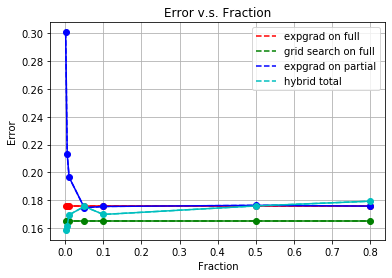

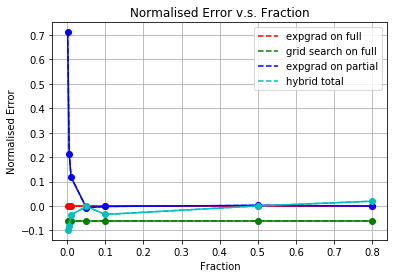

In [10]:
# Print Error and plot them
abs_error = error_expgrad_alls[0]
norm_error_hybrids = []
norm_error_expgrad_fracs = []
norm_error_grid_alls = []
norm_error_expgrad_alls = []

norm_error_exp = (error_expgrad_alls[0] - abs_error)/abs_error
norm_error_grid = (error_grid_alls[0] - abs_error)/abs_error

print('Model\t\t\tFraction\tError\t\tNormalised Error')
print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on full', '-', error_expgrad_alls[0], norm_error_exp))
print('{}\t{}\t\t{}\t{}'.format('Grid Search on full', '-', error_grid_alls[0], norm_error_grid))
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_error = (error_expgrad_fracs[i] - abs_error)/abs_error
    print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on subset',
                                fractions[i], error_expgrad_fracs[i], norm_error))
    
    norm_error_expgrad_fracs.append(norm_error)
    norm_error_expgrad_alls.append(norm_error_exp)
    
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_error = (error_hybrids[i] - abs_error)/abs_error
    print('{}\t\t{}\t\t{}\t{}'.format('Hybrid',
                                fractions[i], error_hybrids[i], norm_error))
    
    norm_error_hybrids.append(norm_error)
    norm_error_grid_alls.append(norm_error_grid)

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, error_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, error_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, error_hybrids,'c--',label="hybrid total")
plt.plot(fractions, error_expgrad_alls,'ro-', fractions, error_grid_alls,'go-',
         fractions, error_expgrad_fracs,'bo-', fractions, error_hybrids,'co-')
plt.xlabel('Fraction')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fractions, norm_error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, norm_error_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, norm_error_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, norm_error_hybrids,'c--',label="hybrid total")
plt.plot(fractions, norm_error_expgrad_alls,'ro-', fractions, norm_error_grid_alls,'go-',
         fractions, norm_error_expgrad_fracs,'bo-', fractions, norm_error_hybrids,'co-')
plt.xlabel('Fraction')
plt.ylabel('Normalised Error')
plt.title('Normalised Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

Model			Fraction	Violation		Normalised Value
Exp.Grad. on full	-		0.007999999999999924	-9.540979117872439e-15
Grid Search on full	-		0.053235051159029406	5.654381394878675
---------------------------------------------
Exp.Grad. on subset	0.001		0.018650889363775264	1.331361170471908
Exp.Grad. on subset	0.005		0.022274040634621343	1.784255079327668
Exp.Grad. on subset	0.01		0.01076532541706203	0.3456656771327537
Exp.Grad. on subset	0.05		0.025765804840933673	2.220725605116709
Exp.Grad. on subset	0.1		0.018542677655781062	1.3178347069726326
Exp.Grad. on subset	0.5		0.0058985792544796745	-0.2626775931900407
Exp.Grad. on subset	0.8		0.008364503662418851	0.045562957802356384
---------------------------------------------
Hybrid	0.001		0.12424042105058944	14.530052631323679
Hybrid	0.005		0.07780047328577896	8.72505916072237
Hybrid	0.01		0.03624185163859095	3.5302314548238685
Hybrid	0.05		0.01305858068367291	0.6323225854591137
Hybrid	0.1		0.03315407538674237	3.1442594233427963
Hybrid	0.5		0.00

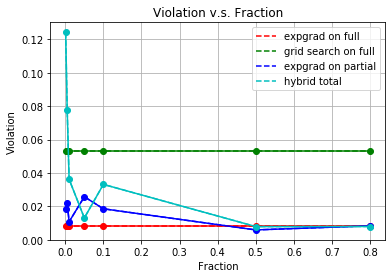

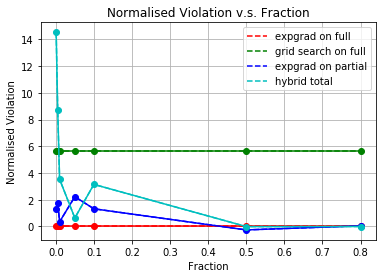

In [11]:
# Print Violation and plot them
norm_vio_hybrids = []
norm_vio_expgrad_fracs = []
norm_vio_grid_alls = []
norm_vio_expgrad_alls = []

norm_vio_exp = (vio_expgrad_alls[0] - eps)/eps
norm_vio_grid = (vio_grid_alls[0] - eps)/eps
print('Model\t\t\tFraction\tViolation\t\tNormalised Value')
print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on full', '-',
                            vio_expgrad_alls[0], norm_vio_exp))
print('{}\t{}\t\t{}\t{}'.format('Grid Search on full', '-',
                            vio_grid_alls[0], norm_vio_grid))

print('---------------------------------------------')
for i in range(len(fractions)):
    norm_vio = (vio_expgrad_fracs[i] - eps)/eps
    print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on subset', fractions[i],
                                    vio_expgrad_fracs[i], norm_vio))
    norm_vio_expgrad_fracs.append(norm_vio)
    norm_vio_expgrad_alls.append(norm_vio_exp)
    
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_vio = (vio_hybrids[i] - eps)/eps
    print('{}\t{}\t\t{}\t{}'.format('Hybrid', fractions[i],
                                    vio_hybrids[i], norm_vio))
    norm_vio_hybrids.append(norm_vio)
    norm_vio_grid_alls.append(norm_vio_grid)
    

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, vio_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, vio_hybrids,'c--',label="hybrid total")
plt.plot(fractions, vio_expgrad_alls,'ro-', fractions, vio_grid_alls,'go-',
         fractions, vio_expgrad_fracs,'bo-', fractions, vio_hybrids,'co-')
plt.xlabel('Fraction')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fractions, norm_vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, norm_vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, norm_vio_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, norm_vio_hybrids,'c--',label="hybrid total")
plt.plot(fractions, norm_vio_expgrad_alls,'ro-', fractions, norm_vio_grid_alls,'go-',
         fractions, norm_vio_expgrad_fracs,'bo-', fractions, norm_vio_hybrids,'co-')
plt.xlabel('Fraction')
plt.ylabel('Normalised Violation')
plt.title('Normalised Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

### Inferences

1. Time: steadily increases (almost linearly) as we increase the subset size.

2. Error: almost all hybrid models showed error lower than exponentiated gradient on full dataset and more than grid search result on full dataset.

3. Violation: There exists a spike in the violation at subset frac = 0.002 and 0.008. However, it was between grid and exponentiated grad (close to exponentiated grad). Not a specific trend.

## Experiment 2: Hybrid 2

### Notes:

1. For grid search in hybrid model, we get `y_pred` using the `weights` from exp grad on partial dataset.

In [12]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [13]:
# hybrid model 2

# Variables
error_grid_pmf_fracs = []
vio_grid_pmf_fracs = []

error_grid_pmf_fracs_std = []
vio_grid_pmf_fracs_std = []

# Iterations on difference fractions
for i,f in enumerate(fractions):
    _error_grid_pmf_fracs = []
    _vio_grid_pmf_fracs = []

    for n in range(num_samples):
        # get samples
        subsampling = train_all.sample(frac=f, random_state=n)
        subsampling = subsampling.reset_index()
        subsampling = subsampling.drop(columns=['index'])
        tmp = subsampling.iloc[:, :-1]
        A_train = subsampling.iloc[:, -1]
        X_train = tmp.iloc[:, :-1]
        y_train = tmp.iloc[:,-1]

        # Expgrad on sub dataset
        expgrad_X_logistic_frac = ExponentiatedGradient(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), eps=eps, nu=1e-6)

        expgrad_X_logistic_frac.fit(X_train, y_train, sensitive_features=A_train)
        
        _weights_logistic = expgrad_X_logistic_frac._weights

        
        # Grid Search part
        lambda_vecs_logistic = expgrad_X_logistic_frac._lambda_vecs_lagrangian
        grid_search_logistic_frac = GridSearch(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), grid=lambda_vecs_logistic)
        grid_search_logistic_frac.fit(X_train_all, y_train_all,
                                      sensitive_features=A_train_all)
        _predictors = grid_search_logistic_frac._predictors
        
        def Qlog(X): return _pmf_predict(X, _predictors, _weights_logistic)[:,1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        violation_grid_search_pmf = disparity_moment.gamma(Qlog).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        error_grid_search_pmf = error.gamma(Qlog)[0]

        _vio_grid_pmf_fracs.append(violation_grid_search_pmf)
        _error_grid_pmf_fracs.append(error_grid_search_pmf)

    vio_grid_pmf_fracs.append((sum(_vio_grid_pmf_fracs)) / num_samples)
    error_grid_pmf_fracs.append((sum(_error_grid_pmf_fracs)) / num_samples)
    
    error_grid_pmf_fracs_std.append(statistics.stdev(_error_grid_pmf_fracs))
    vio_grid_pmf_fracs_std.append(statistics.stdev(_vio_grid_pmf_fracs))

Model			Fraction	Error	Normalised Error
Exp.Grad. on full	-		0.17583524270832335	0.0
Grid Search on full	-		0.16535118700285617	-0.05962431389740336
---------------------------------------------
Exp.Grad. on subset	0.001		0.3008918920207032	0.7112149270315773
Exp.Grad. on subset	0.005		0.2133624494187938	0.2134225547305145
Exp.Grad. on subset	0.01		0.1965484552328447	0.11779898162327199
Exp.Grad. on subset	0.05		0.1746010161836783	-0.007019221548733536
Exp.Grad. on subset	0.1		0.17550936017638147	-0.0018533402458030274
Exp.Grad. on subset	0.5		0.17629889726138454	0.002636869298325485
Exp.Grad. on subset	0.8		0.17575621397000749	-0.0004494476596307547
---------------------------------------------
Hybrid	0.001		0.2617509260413858	0.4886146941292078
Hybrid	0.005		0.1875726322218076	0.06675220128057206
Hybrid	0.01		0.16545475044187824	-0.0590353339100759
Hybrid	0.05		0.16587431097439254	-0.05664923356948453
Hybrid	0.1		0.16839481081939378	-0.04231479295235372
Hybrid	0.5		0.1745038549825275

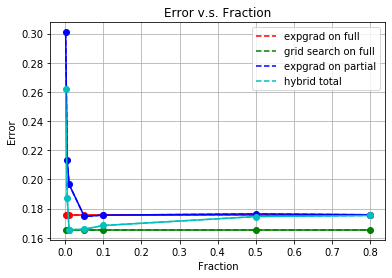

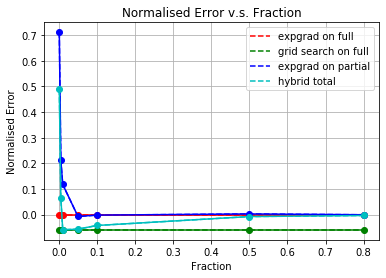

In [14]:
# Print Error and plot them
abs_error = error_expgrad_alls[0]
norm_error_grid_pmf_fracs = []
norm_error_expgrad_fracs = []
norm_error_grid_alls = []
norm_error_expgrad_alls = []

norm_error_exp = (error_expgrad_alls[0] - abs_error)/abs_error
norm_error_grid = (error_grid_alls[0] - abs_error)/abs_error

print('Model\t\t\tFraction\tError\tNormalised Error')
print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on full', '-', error_expgrad_alls[0], norm_error_exp))
print('{}\t{}\t\t{}\t{}'.format('Grid Search on full', '-', error_grid_alls[0], norm_error_grid))
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_error = (error_expgrad_fracs[i] - abs_error)/abs_error
    print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on subset',
                                fractions[i], error_expgrad_fracs[i], norm_error))
    
    norm_error_expgrad_fracs.append(norm_error)
    norm_error_expgrad_alls.append(norm_error_exp)
    
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_error = (error_grid_pmf_fracs[i] - abs_error)/abs_error
    print('{}\t{}\t\t{}\t{}'.format('Hybrid',
                                fractions[i], error_grid_pmf_fracs[i], norm_error))
    
    norm_error_grid_pmf_fracs.append(norm_error)
    norm_error_grid_alls.append(norm_error_grid)

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, error_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, error_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, error_grid_pmf_fracs,'c--',label="hybrid total")
plt.plot(fractions, error_expgrad_alls,'ro-', fractions, error_grid_alls,'go-',
         fractions, error_expgrad_fracs,'bo-', fractions, error_grid_pmf_fracs,'co-')
plt.xlabel('Fraction')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fractions, norm_error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, norm_error_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, norm_error_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, norm_error_grid_pmf_fracs,'c--',label="hybrid total")
plt.plot(fractions, norm_error_expgrad_alls,'ro-', fractions, norm_error_grid_alls,'go-',
         fractions, norm_error_expgrad_fracs,'bo-', fractions, norm_error_grid_pmf_fracs,'co-')
plt.xlabel('Fraction')
plt.ylabel('Normalised Error')
plt.title('Normalised Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

Model			Fraction	Violation		Normalised Value
Exp.Grad. on full	-		0.007999999999999924	-9.540979117872439e-15
Grid Search on full	-		0.053235051159029406	5.654381394878675
---------------------------------------------
Exp.Grad. on subset	0.001		0.018650889363775264	1.331361170471908
Exp.Grad. on subset	0.005		0.022274040634621343	1.784255079327668
Exp.Grad. on subset	0.01		0.01076532541706203	0.3456656771327537
Exp.Grad. on subset	0.05		0.025765804840933673	2.220725605116709
Exp.Grad. on subset	0.1		0.018542677655781062	1.3178347069726326
Exp.Grad. on subset	0.5		0.0058985792544796745	-0.2626775931900407
Exp.Grad. on subset	0.8		0.008364503662418851	0.045562957802356384
---------------------------------------------
Hybrid	0.001		0.12927310684965762	15.159138356207201
Hybrid	0.005		0.01507486565201177	0.8843582065014713
Hybrid	0.01		0.05601288753844249	6.0016109423053114
Hybrid	0.05		0.05347924001182532	5.684905001478165
Hybrid	0.1		0.04123745581995679	4.154681977494598
Hybrid	0.5		0.01

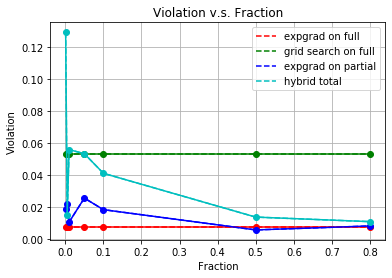

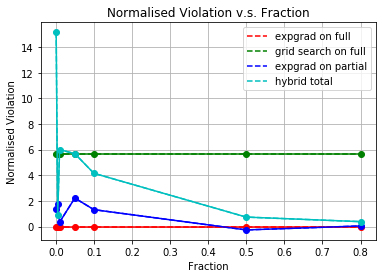

In [15]:
# Print Violation and plot them
norm_vio_grid_pmf_fracs = []
norm_vio_expgrad_fracs = []
norm_vio_grid_alls = []
norm_vio_expgrad_alls = []

norm_vio_exp = (vio_expgrad_alls[0] - eps)/eps
norm_vio_grid = (vio_grid_alls[0] - eps)/eps
print('Model\t\t\tFraction\tViolation\t\tNormalised Value')
print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on full', '-',
                            vio_expgrad_alls[0], norm_vio_exp))
print('{}\t{}\t\t{}\t{}'.format('Grid Search on full', '-',
                            vio_grid_alls[0], norm_vio_grid))

print('---------------------------------------------')
for i in range(len(fractions)):
    norm_vio = (vio_expgrad_fracs[i] - eps)/eps
    print('{}\t{}\t\t{}\t{}'.format('Exp.Grad. on subset', fractions[i],
                                    vio_expgrad_fracs[i], norm_vio))
    norm_vio_expgrad_fracs.append(norm_vio)
    norm_vio_expgrad_alls.append(norm_vio_exp)
    
print('---------------------------------------------')
for i in range(len(fractions)):
    norm_vio = (vio_grid_pmf_fracs[i] - eps)/eps
    print('{}\t{}\t\t{}\t{}'.format('Hybrid', fractions[i],
                                    vio_grid_pmf_fracs[i], norm_vio))
    norm_vio_grid_pmf_fracs.append(norm_vio)
    norm_vio_grid_alls.append(norm_vio_grid)
    

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, vio_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, vio_grid_pmf_fracs,'c--',label="hybrid total")
plt.plot(fractions, vio_expgrad_alls,'ro-', fractions, vio_grid_alls,'go-',
         fractions, vio_expgrad_fracs,'bo-', fractions, vio_grid_pmf_fracs,'co-')
plt.xlabel('Fraction')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fractions, norm_vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, norm_vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, norm_vio_expgrad_fracs,'b--',label="expgrad on partial")
l4 = plt.plot(fractions, norm_vio_grid_pmf_fracs,'c--',label="hybrid total")
plt.plot(fractions, norm_vio_expgrad_alls,'ro-', fractions, norm_vio_grid_alls,'go-',
         fractions, norm_vio_expgrad_fracs,'bo-', fractions, norm_vio_grid_pmf_fracs,'co-')
plt.xlabel('Fraction')
plt.ylabel('Normalised Violation')
plt.title('Normalised Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

Fraction	Normalised Error	Normalised Violation
0.001		0.4886146941292078	15.159138356207201
0.005		0.06675220128057206	0.8843582065014713
0.01		-0.0590353339100759	6.0016109423053114
0.05		-0.05664923356948453	5.684905001478165
0.1		-0.04231479295235372	4.154681977494598
0.5		-0.007571791099946264	0.7375253015718787
0.8		-0.0033793436354964297	0.3825500811908558
----------------------------------------------
0.001		-0.09787510796435514	14.530052631323679
0.005		-0.08084564485235607	8.72505916072237
0.01		-0.03604505728078913	3.5302314548238685
0.05		-0.001986131056790987	0.6323225854591137
0.1		-0.034560437419742976	3.1442594233427963
0.5		0.00028446402480896294	-0.012074545323017584
0.8		0.019584522218407986	-0.007619711371468184


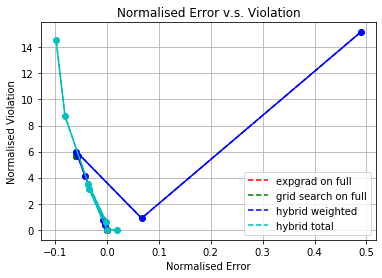

In [16]:
# Violation vs error
print('{}\t{}\t{}'.format('Fraction', 'Normalised Error', 'Normalised Violation'))
for i in range(len(fractions)):
    print('{}\t\t{}\t{}'.format(fractions[i], norm_error_grid_pmf_fracs[i], norm_vio_grid_pmf_fracs[i]))

print('----------------------------------------------')
for i in range(len(fractions)):
    print('{}\t\t{}\t{}'.format(fractions[i], norm_error_hybrids[i], norm_vio_hybrids[i]))

l1 = plt.plot(norm_error_expgrad_alls, norm_vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(norm_error_grid_alls, norm_vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(norm_error_grid_pmf_fracs, norm_vio_grid_pmf_fracs,'b--',label="hybrid weighted")
l4 = plt.plot(norm_error_hybrids, norm_vio_hybrids,'c--',label="hybrid total")
plt.plot(norm_error_expgrad_alls, norm_vio_expgrad_alls,'ro-', norm_error_grid_alls, norm_vio_grid_alls,'go-',
         norm_error_grid_pmf_fracs, norm_vio_grid_pmf_fracs,'bo-', norm_error_hybrids, norm_vio_hybrids,'co-')
plt.xlabel('Normalised Error')
plt.ylabel('Normalised Violation')
plt.title('Normalised Error v.s. Violation')
plt.grid()
plt.legend()
plt.show()

### Inferences

1. Error: almost all hybrid models showed error lower than exponentiated gradient on full dataset and more than grid search result on full dataset. Stabilises after subset=0.02

2. Violation: There exists an initial spike in the violation. However, it stabilises after subset=0.02.

## Experiment 3: Hybrid 3

### Notes:

1. For grid search in hybrid model, we get `y_pred` by evaluating LP over the grid predictors to re-assign `weights` to each predictor.

In [17]:
# def _pmf_predict(X, predictors, weights):
#     pred = pd.DataFrame()
#     for t in range(len(predictors)):
#         pred[t] = predictors[t].predict(X)
#     positive_probs = pred[weights.index].dot(weights).to_frame()
#     return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [18]:
# from fairlearn.reductions._exponentiated_gradient import _Lagrangian


In [19]:
# error_grid_pmf_fracs_reweighted = []
# vio_grid_pmf_fracs_reweighted = []

# stored_reweights = []
# stored_lambdas = []
# stored_result_lp = []

# for i in range(len(fractions)):
#     predictors = predictors_grid_fracs[i]
    
#     # run LP on final predictors -- TODO
#     B = 1 / eps
#     lagrangian = _Lagrangian(X_train_all, A_train_all, y_train_all, predictors,
#                         DemographicParity(), eps, B)
#     Q_LP, lambda_vecs_LP, result_LP = lagrangian.solve_linprog(1e-6)
#     gap_LP = result_LP.gap()
#     print(gap_LP)
    
#     stored_reweights.append(Q_LP)
#     stored_lambdas.append(lambda_vecs_LP)
#     stored_result_lp.append(result_LP)
    
    
# #     def Qlog(X): return _pmf_predict(X, predictors, weights_logistic)[:,1]
# #     # violation of log res
# #     disparity_moment = DemographicParity()
# #     disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
# #     violation_grid_search_pmf = disparity_moment.gamma(Qlog).max()

# #     # error of log res
# #     error = ErrorRate()
# #     error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
# #     error_grid_search_pmf = error.gamma(Qlog)[0]
    
# #     vio_grid_pmf_fracs_reweighted.append(violation_grid_search_pmf)
# #     error_grid_pmf_fracs_reweighted.append(error_grid_search_pmf)
    

# Experiment Results

Model	Error
Exp.Grad. on full	0.17583524270832335
Grid Search on full	0.16535118700285617
---------------------------------------------
Fraction	Error (hybrid 1)	Error (hybrid 2)	
0.001	0.1586253493443076		0.2617509260413858
0.005	0.1616197291237984		0.1875726322218076
0.01	0.16949725131292037		0.16545475044187824
0.05	0.17548601087190197		0.16587431097439254
0.1	0.16975829980651702		0.16839481081939378
0.5	0.17588526150916742		0.17450385498252757
0.8	0.17927889192592367		0.175241034999981


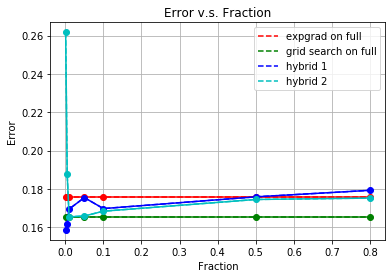

In [20]:
# Print Error and plot them
print('Model\tError')
print('{}\t{}'.format('Exp.Grad. on full', error_expgrad_alls[0]))
print('{}\t{}'.format('Grid Search on full', error_grid_alls[0]))
print('---------------------------------------------')
print('Fraction\tError (hybrid 1)\tError (hybrid 2)\t')

for i in range(len(fractions)):
    print('{}\t{}\t\t{}'.format(fractions[i], error_hybrids[i], error_grid_pmf_fracs[i]))

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, error_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, error_hybrids,'b--',label="hybrid 1")
l4 = plt.plot(fractions, error_grid_pmf_fracs,'c--',label="hybrid 2")
plt.plot(fractions, error_expgrad_alls,'ro-', fractions, error_grid_alls,'go-',
         fractions, error_hybrids,'bo-', fractions, error_grid_pmf_fracs,'co-')
plt.xlabel('Fraction')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

Model	Violation
Exp.Grad. on full	0.007999999999999924
Grid Search on full	0.053235051159029406
---------------------------------------------
Fraction	Vio (hybrid 1)	Vio (hybrid 2)
0.001	0.12424042105058944		0.12927310684965762
0.005	0.07780047328577896		0.01507486565201177
0.01	0.03624185163859095		0.05601288753844249
0.05	0.01305858068367291		0.05347924001182532
0.1	0.03315407538674237		0.04123745581995679
0.5	0.00790340363741586		0.01390020241257503
0.8	0.007939042309028255		0.011060400649526847


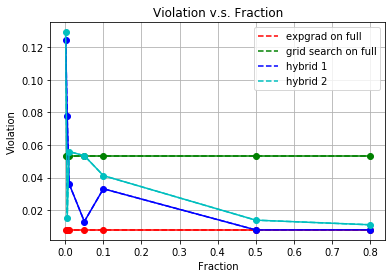

In [21]:
# Print Violation and plot them
print('Model\tViolation')
print('{}\t{}'.format('Exp.Grad. on full', vio_expgrad_alls[0]))
print('{}\t{}'.format('Grid Search on full', vio_grid_alls[0]))
print('---------------------------------------------')

print('Fraction\tVio (hybrid 1)\tVio (hybrid 2)')
for i in range(len(fractions)):
    print('{}\t{}\t\t{}'.format(fractions[i], vio_hybrids[i], vio_grid_pmf_fracs[i]))

import matplotlib.pyplot as plt

l1 = plt.plot(fractions, vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fractions, vio_grid_alls,'g--',label="grid search on full")
l3 = plt.plot(fractions, vio_hybrids,'b--',label="hybrid 1")
l4 = plt.plot(fractions, vio_grid_pmf_fracs,'c--',label="hybrid 2")
plt.plot(fractions, vio_expgrad_alls,'ro-', fractions, vio_grid_alls,'go-',
         fractions, vio_hybrids,'bo-', fractions, vio_grid_pmf_fracs,'co-')
plt.xlabel('Fraction')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()